In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import pymc.sampling_jax
import arviz as az
import xarray as xr
from numpy.polynomial.polynomial import Polynomial
import scipy.stats as stats
import warnings
from pymc import HalfCauchy, Model, Normal, sample

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

/Users/corrado/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
sns.set_theme(palette="colorblind")

In [3]:
size = 200 # numero di osservazioni nel campione
true_intercept = 1 # alpha
true_slope = 2 # beta

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + rng.normal(scale=0.5, size=size) # sigma = 0.5

data = pd.DataFrame(dict(x=x, y=y))
data.head()

,x,y
0,0.000000,1.152359
1,0.005025,0.490058
2,0.010050,1.395326
3,0.015075,1.500433
4,0.020101,0.064683


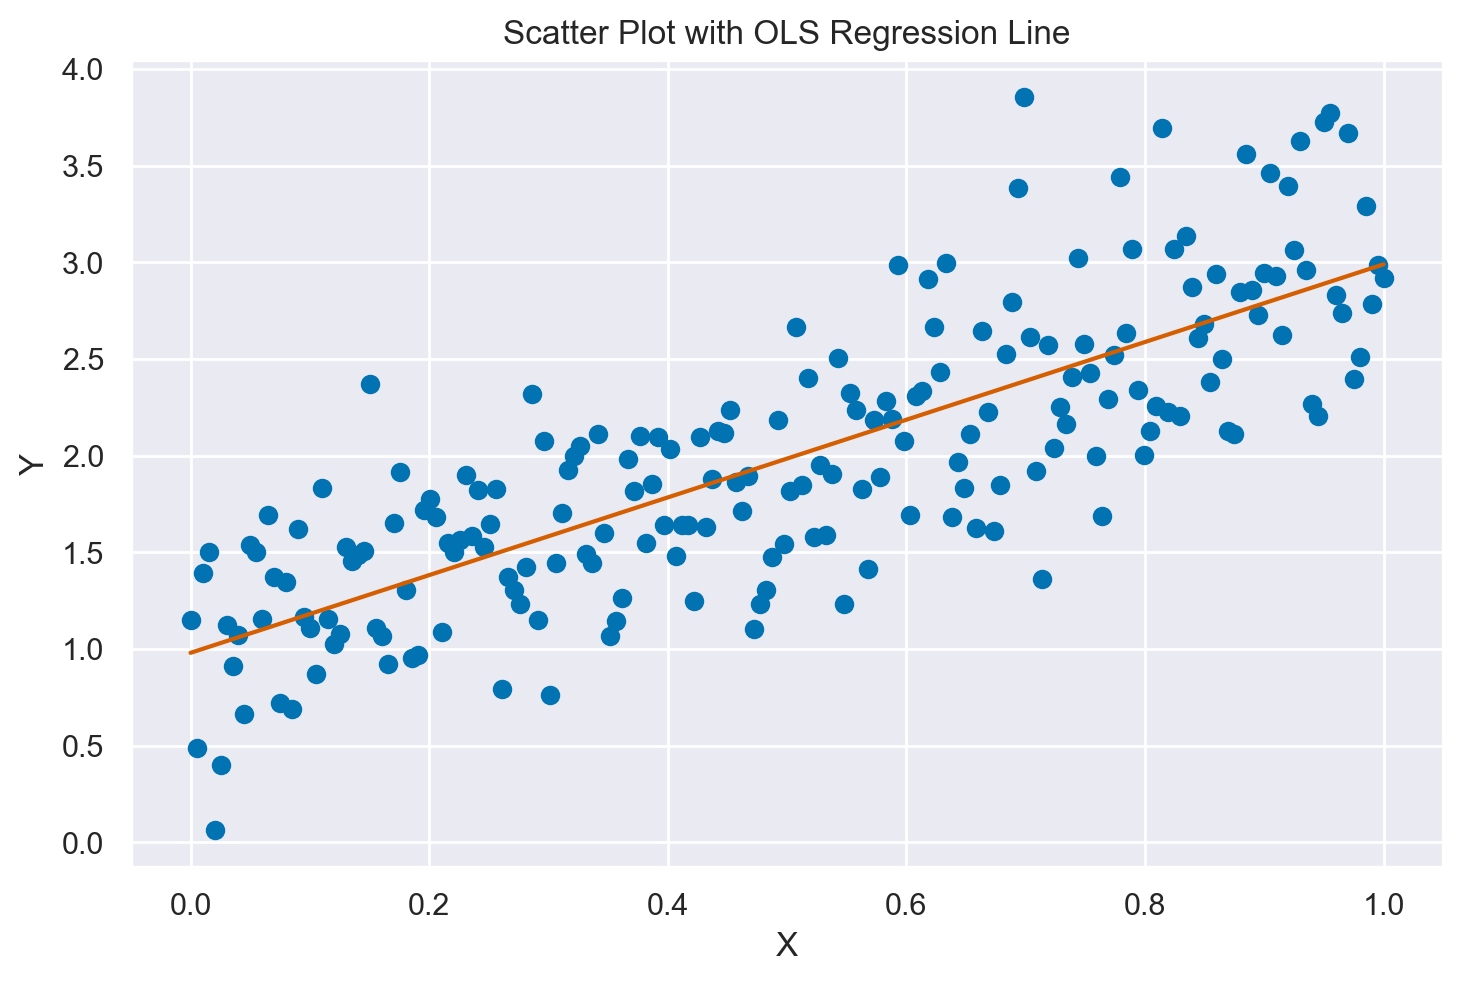

In [4]:
# Creating a scatter plot
plt.scatter(x, y)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Scatter Plot with OLS Regression Line")

# Fitting a linear regression
linear_regression = Polynomial.fit(data["x"], data["y"], 1)

# Plotting the regression line
plt.plot(data["x"], linear_regression(data["x"]), color="C3")
plt.show()

In [5]:
# Log-Gaussian likelihood 
def log_gaussian_likelihood(y, mu, sigma_squared):
    return stats.norm.logpdf(y, loc=mu, scale=np.sqrt(sigma_squared))

In [6]:
# Log-Gaussian prior
def log_gaussian_prior(param, mean=0, variance=1):
    return stats.norm.logpdf(param, loc=mean, scale=np.sqrt(variance))

In [7]:
# Log-Posterior calculation
def calc_log_posterior(a, b, y=y, x=x, sigma_squared=1.0):
    mu = a + b * x
    log_likelihood = log_gaussian_likelihood(y, mu, sigma_squared)
    log_prior_a = log_gaussian_prior(a)
    log_prior_b = log_gaussian_prior(b)
    return np.sum(log_likelihood) + log_prior_a + log_prior_b

In [8]:
# Brute-force grid search for posterior visualization
X1 = np.linspace(0, 3, 101)  # alpha (intercept)
X2 = np.linspace(0, 3, 100)  # beta (slope)
log_pp = np.zeros((101, 100))

k = 0
for x1 in X1:
    j = 0
    for x2 in X2:
        log_pp[k, j] = calc_log_posterior(x1, x2)
        j += 1
    k += 1

In [9]:
# To visualize in the original scale, we can exponentiate log_pp
pp = np.exp(log_pp - np.max(log_pp))  # Subtract the max for numerical stability

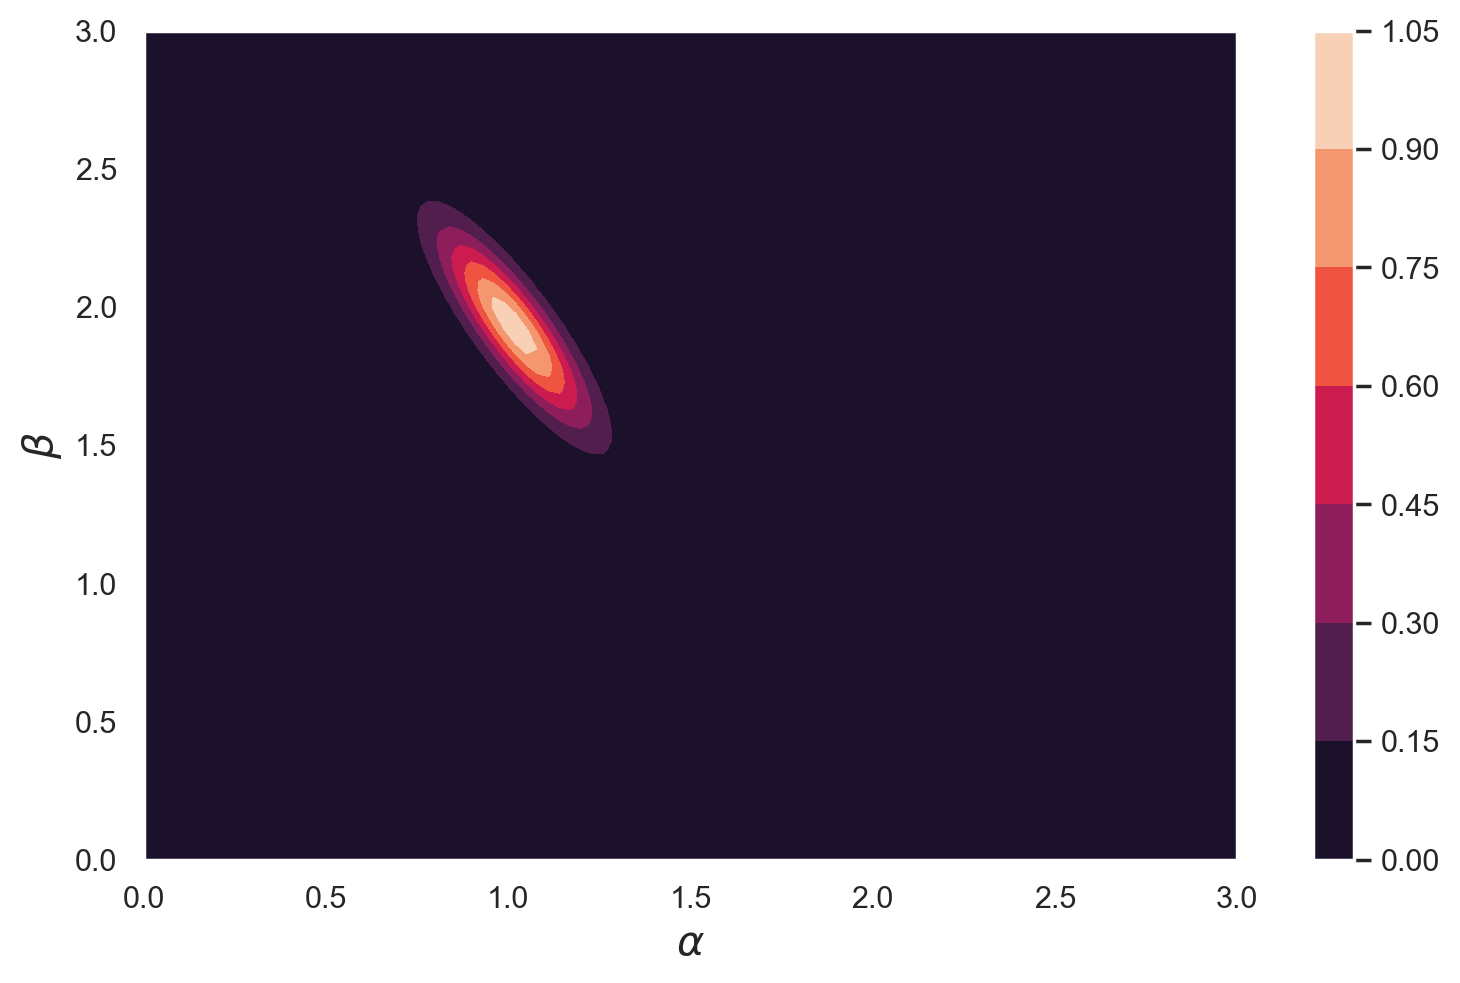

In [10]:
plt.contourf(X1, X2, pp.T)
plt.xlabel("$\\alpha$", size=15)
plt.ylabel("$\\beta$", size=15)
plt.colorbar()
plt.show()

In [11]:
with Model() as model:
    # Define priors
    alpha = pm.Normal("alpha", sigma=1)
    beta = pm.Normal("beta", sigma=1)
    sigma = pm.HalfNormal("sigma", sigma=5)
    # Define likelihood
    pm.Normal("y_obs", mu=alpha + beta * x, sigma=sigma, observed=y)

In [12]:
with model:
    idata = pm.sampling_jax.sample_numpyro_nuts()

Compiling...


Compilation time = 0:00:00.883123


Sampling...


  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

Running chain 3:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 0:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 1:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 2:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 0: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1523.06it/s]


Running chain 1: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1524.42it/s]


Running chain 2: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1525.71it/s]


Running chain 3: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1526.90it/s]


Sampling time = 0:00:01.534443


Transforming variables...


Transformation time = 0:00:00.072226


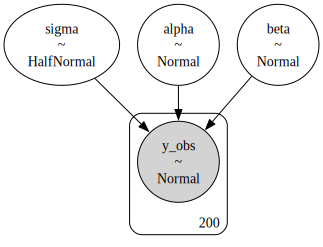

In [13]:
pm.model_to_graphviz(model)

In [14]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [15]:
idata.posterior["alpha"].shape

(4, 1000)

In [16]:
idata.posterior["alpha"][0, 0:5]

<xarray.DataArray 'alpha' (draw: 5)>
array([0.97780929, 0.99705298, 0.92361408, 0.90462599, 0.98154403])
Coordinates:
    chain    int64 0
  * draw     (draw) int64 0 1 2 3 4

In [17]:
idata.posterior["alpha"][1, 0:5]

<xarray.DataArray 'alpha' (draw: 5)>
array([1.11869567, 1.05039239, 1.02095221, 0.96159283, 0.96599807])
Coordinates:
    chain    int64 1
  * draw     (draw) int64 0 1 2 3 4

In [18]:
idata.posterior["beta"].shape

(4, 1000)

In [19]:
data["x"].shape

(200,)

In [20]:
print(*data.x[0:5])

0.0 0.005025125628140704 0.010050251256281407 0.01507537688442211 0.020100502512562814


In [21]:
print(*y[0:5])

1.1523585398772156 0.4900581981360337 1.3953261004157915 1.5004331119644512 0.06468341069820738


In [22]:
print(idata.observed_data.y_obs[0:5].values)

[1.15235854 0.4900582  1.3953261  1.50043311 0.06468341]


In [23]:
idata.posterior["alpha"].mean().item()

0.98382122340293

In [24]:
idata.posterior["beta"].mean().item()

1.9978597881959548

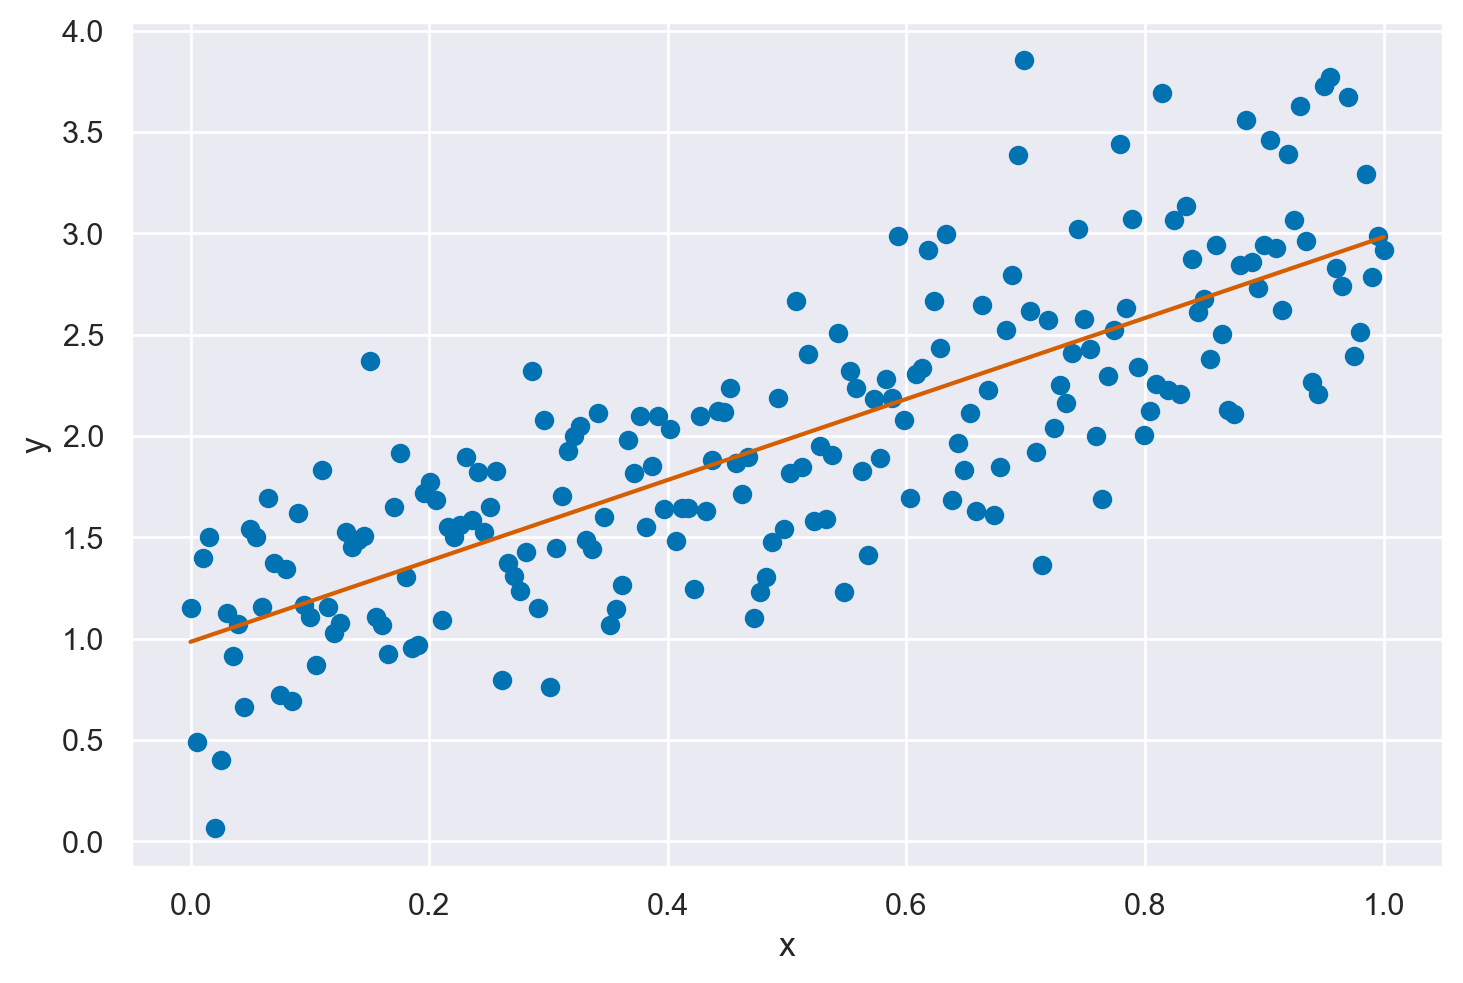

In [25]:
plt.plot(x, y, "C0o")
plt.plot(
    x,
    idata.posterior["alpha"].mean().item()
    + idata.posterior["beta"].mean().item() * x,
    "C3"
)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [26]:
idata.posterior["y_model"] = idata.posterior["alpha"] + idata.posterior[
    "beta"
] * xr.DataArray(x)
idata.posterior["y_model"].shape

(4, 1000, 200)

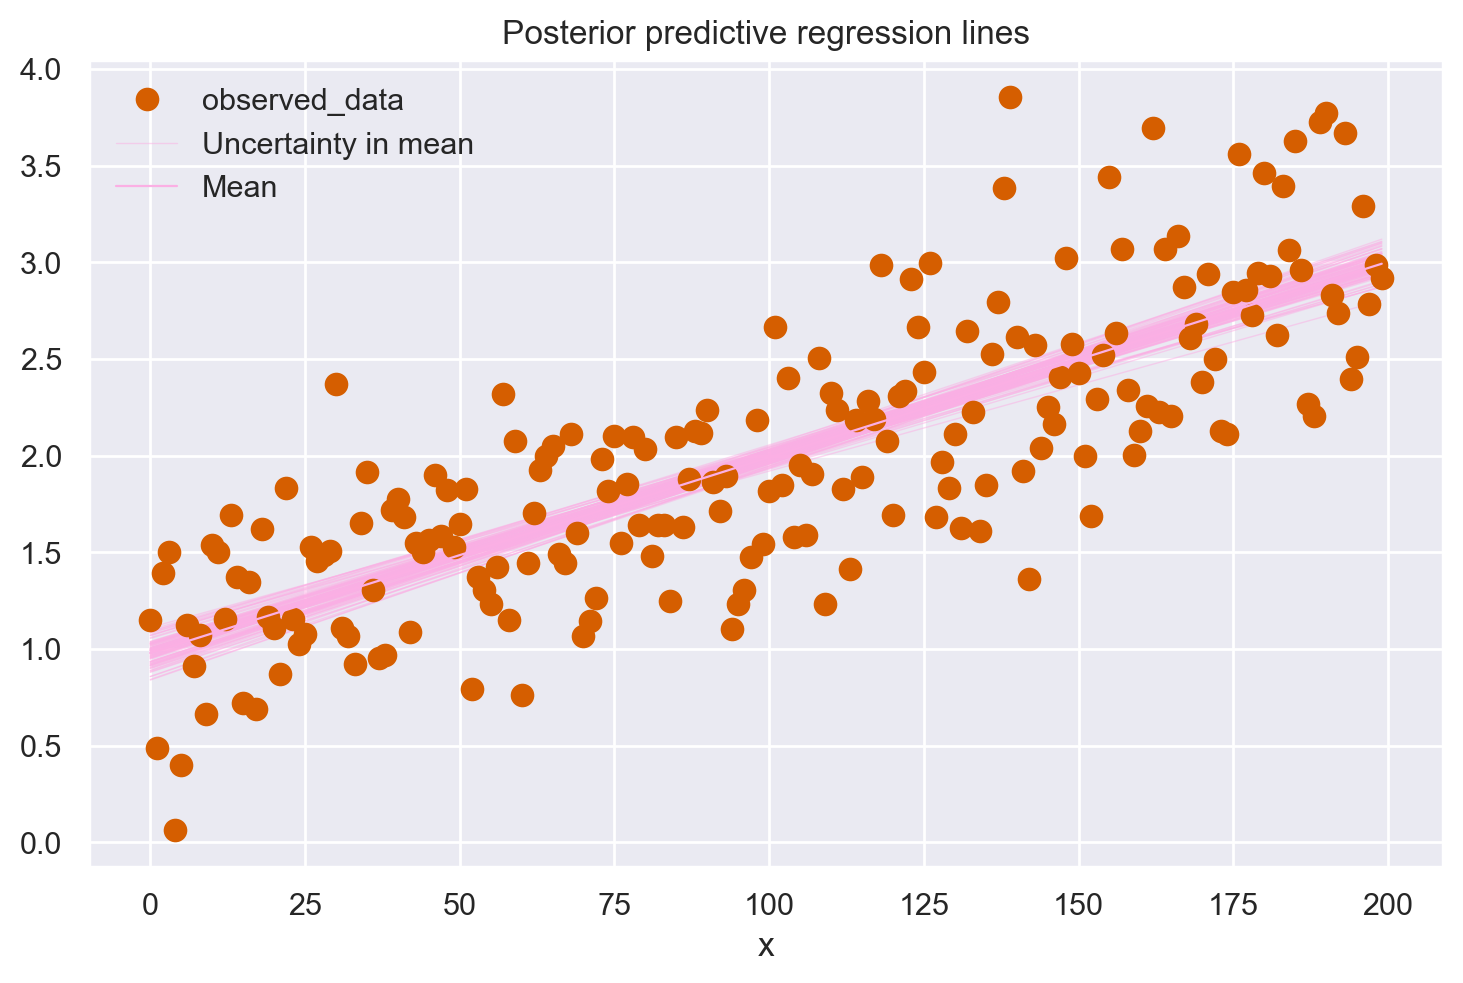

In [27]:
az.plot_lm(idata=idata, y=y, num_samples=100, y_model="y_model")
plt.title("Posterior predictive regression lines")
plt.xlabel("x");

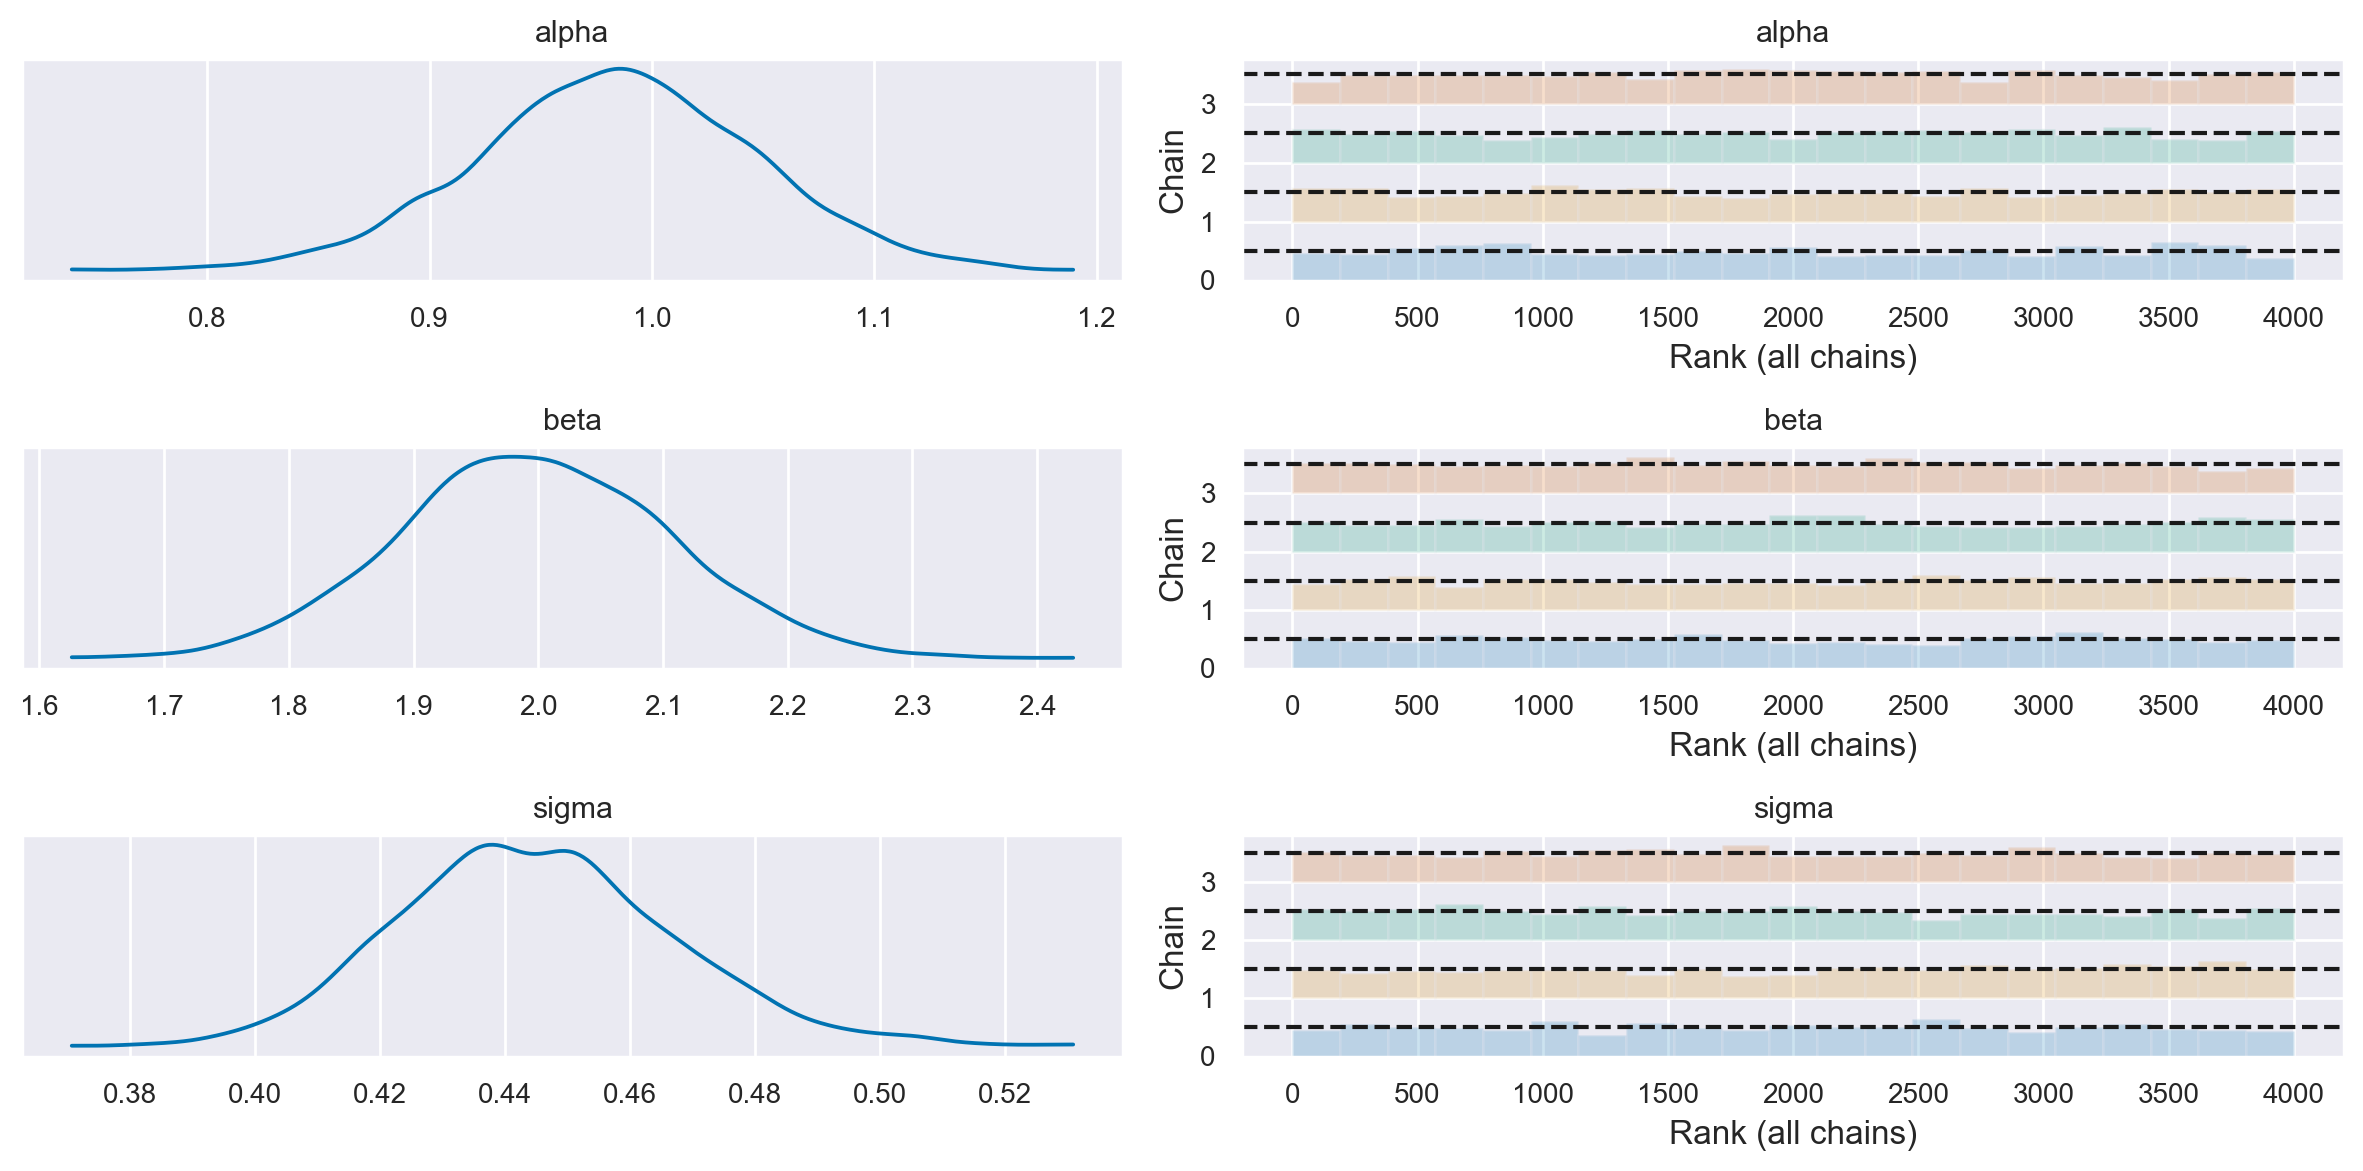

In [28]:
var_names = ["alpha", "beta", "sigma"]
az.plot_trace(idata, var_names=var_names, combined=True, kind="rank_bars")
plt.tight_layout()
plt.show()

In [29]:
params = ["alpha", "beta", "sigma"]
az.summary(idata, var_names = params, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.98,0.06,0.86,1.10,0.0,0.0,1364.87,1502.37,1.0
beta,2.00,0.11,1.79,2.20,0.0,0.0,1386.54,1473.02,1.0
sigma,0.45,0.02,0.40,0.48,0.0,0.0,1996.33,2028.28,1.0


In [30]:
idata.posterior['alpha']

<xarray.DataArray 'alpha' (chain: 4, draw: 1000)>
array([[0.97780929, 0.99705298, 0.92361408, ..., 0.93976961, 1.00014003,
        1.00760297],
       [1.11869567, 1.05039239, 1.02095221, ..., 0.91523733, 0.94813554,
        0.95891383],
       [1.09853987, 1.11343852, 1.14307193, ..., 0.92925039, 0.94407869,
        0.93354609],
       [0.9016651 , 0.86489237, 0.96940012, ..., 1.09982893, 0.99607425,
        1.00433933]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999

In [31]:
alpha_array = idata.posterior['alpha'].values
beta_array = idata.posterior['beta'].values

print("Shape of alpha_array:", alpha_array.shape)
print("Shape of beta_array:", beta_array.shape) 

Shape of alpha_array: (4, 1000)
Shape of beta_array: (4, 1000)


In [32]:
# Flatten the 2D arrays into 1D arrays
alpha_flat = alpha_array.ravel()
beta_flat = beta_array.ravel()

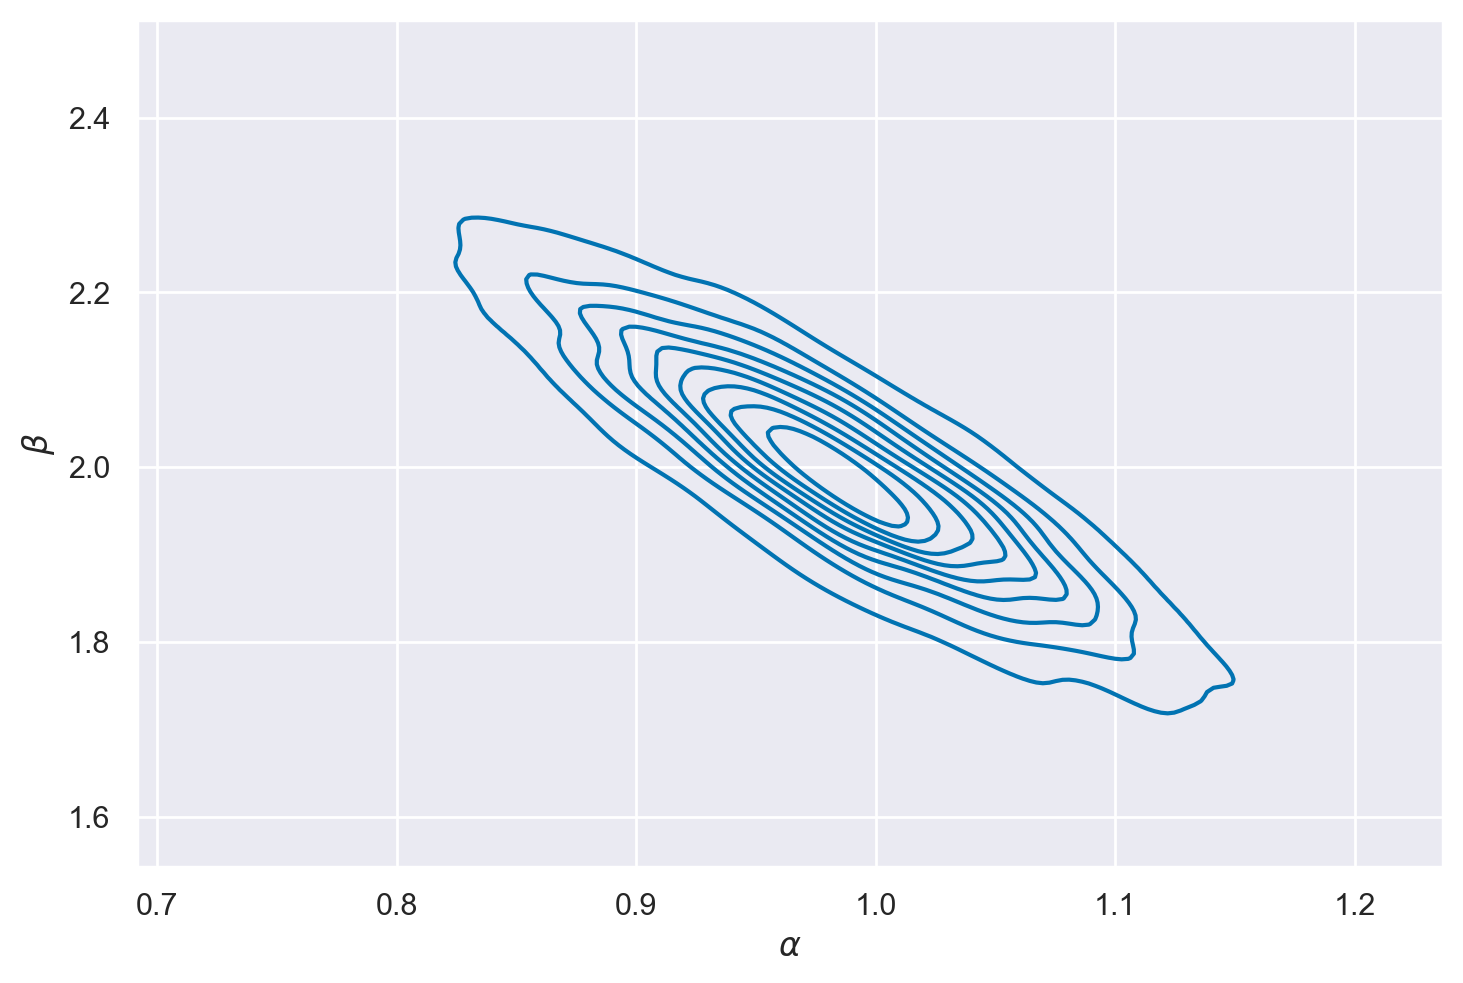

In [33]:
# Create the KDE plot
sns.kdeplot(x=alpha_flat, y=beta_flat)
plt.xlabel("$\\alpha$")
plt.ylabel("$\\beta$")
plt.show()

In [34]:
with model:
    prior_samples = pm.sample_prior_predictive(100)

Sampling: [alpha, beta, sigma, y_obs]


In [35]:
prior = prior_samples.prior
prior

<xarray.Dataset>
Dimensions:  (chain: 1, draw: 100)
Coordinates:
  * chain    (chain) int64 0
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 9 ... 90 91 92 93 94 95 96 97 98 99
Data variables:
    sigma    (chain, draw) float64 0.06575 2.976 6.389 ... 2.176 4.745 0.9838
    alpha    (chain, draw) float64 0.3531 -0.7938 -0.11 ... -1.471 -1.821 -1.001
    beta     (chain, draw) float64 -1.721 1.112 1.632 ... -0.3435 1.8 -0.119
Attributes:
    created_at:                 2024-01-26T17:50:26.008533
    arviz_version:              0.17.0
    inference_library:          pymc
    inference_library_version:  5.10.3

In [36]:
x = xr.DataArray(np.linspace(0, 1, 50))
x

<xarray.DataArray (dim_0: 50)>
array([0.        , 0.02040816, 0.04081633, 0.06122449, 0.08163265,
       0.10204082, 0.12244898, 0.14285714, 0.16326531, 0.18367347,
       0.20408163, 0.2244898 , 0.24489796, 0.26530612, 0.28571429,
       0.30612245, 0.32653061, 0.34693878, 0.36734694, 0.3877551 ,
       0.40816327, 0.42857143, 0.44897959, 0.46938776, 0.48979592,
       0.51020408, 0.53061224, 0.55102041, 0.57142857, 0.59183673,
       0.6122449 , 0.63265306, 0.65306122, 0.67346939, 0.69387755,
       0.71428571, 0.73469388, 0.75510204, 0.7755102 , 0.79591837,
       0.81632653, 0.83673469, 0.85714286, 0.87755102, 0.89795918,
       0.91836735, 0.93877551, 0.95918367, 0.97959184, 1.        ])
Dimensions without coordinates: dim_0

In [37]:
np.array(az.extract_dataset(prior_samples["prior"])["alpha"][:50])

array([ 0.35310503, -0.79382141, -0.10995451, -0.04370647, -1.42257274,
        0.89650124, -0.43361745, -0.27415306,  0.54051866, -0.12713425,
        0.39671138,  0.76953849,  0.86771355, -0.1119953 , -0.47821342,
       -1.86213917,  0.74299604, -1.31182527, -0.78189487,  2.3899627 ,
       -0.47438242, -0.34250326, -0.76047486, -1.89225079,  1.34155073,
        0.16915055, -1.89307424, -1.61511088, -0.19160017,  1.47601927,
        1.03147054,  1.91053496,  1.34075032,  0.19147433, -0.77794752,
       -1.66793467,  0.49996608, -0.23119139,  0.54251932, -0.74160473,
        1.64228705, -1.02601627,  1.4460641 ,  2.04946134,  1.55209686,
       -2.55980722, -0.73592306, -1.18592293,  0.36319252,  0.56446506])

In [38]:
np.array(az.extract_dataset(prior_samples["prior"])["beta"][:50])

array([-1.72079676,  1.11241779,  1.63195218,  0.91402319, -1.37327166,
       -0.08368582,  1.42245874,  1.08660875,  0.82702879, -0.45388436,
       -0.2124282 , -0.8975534 ,  0.55927573, -0.08953683,  0.22455455,
        1.2758374 , -1.34846829,  2.38711146, -0.55291345,  1.13343547,
        0.88862035,  0.60152449, -0.10565457, -0.01561469, -1.68582363,
        0.95666731,  1.36033855,  1.65302989, -0.00473022,  0.36461719,
        0.0517497 ,  0.07440318, -1.07851256, -0.6437617 , -0.21244439,
        0.79180895,  1.1701875 , -0.25035269,  0.60673604,  1.1897245 ,
        0.82241576,  1.23834132, -0.69392075,  1.20649165,  0.58524387,
       -0.3780548 , -1.87676096,  2.26979855, -1.18369522,  1.21615272])

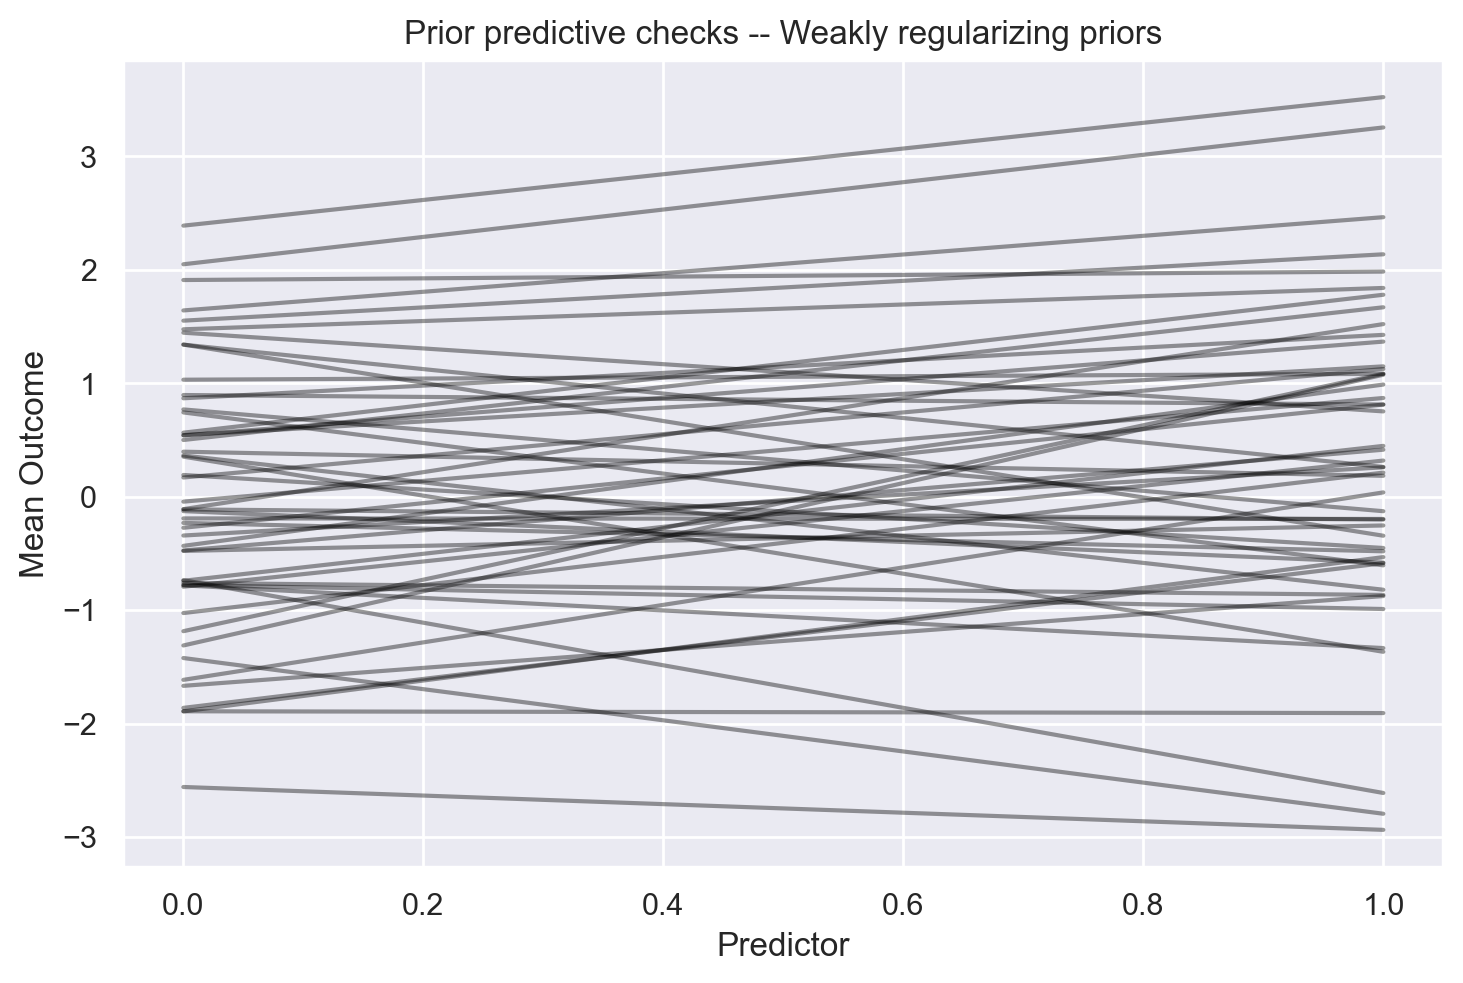

In [39]:
prior_samp_alpha = np.array(az.extract_dataset(prior_samples["prior"])["alpha"][:50])
prior_samp_beta = np.array(az.extract_dataset(prior_samples["prior"])["beta"][:50])

# Plotting the prior samples
for alpha, beta in zip(prior_samp_alpha, prior_samp_beta):
    y = alpha + beta * x
    plt.plot(x, y, c="black", alpha=0.4)

# Setting labels and title
plt.xlabel("Predictor")
plt.ylabel("Mean Outcome")
plt.title("Prior predictive checks -- Weakly regularizing priors")
plt.show()

In [40]:
with model:
    pm.sample_posterior_predictive(
        idata, extend_inferencedata=True, random_seed=rng);

Sampling: [y_obs]


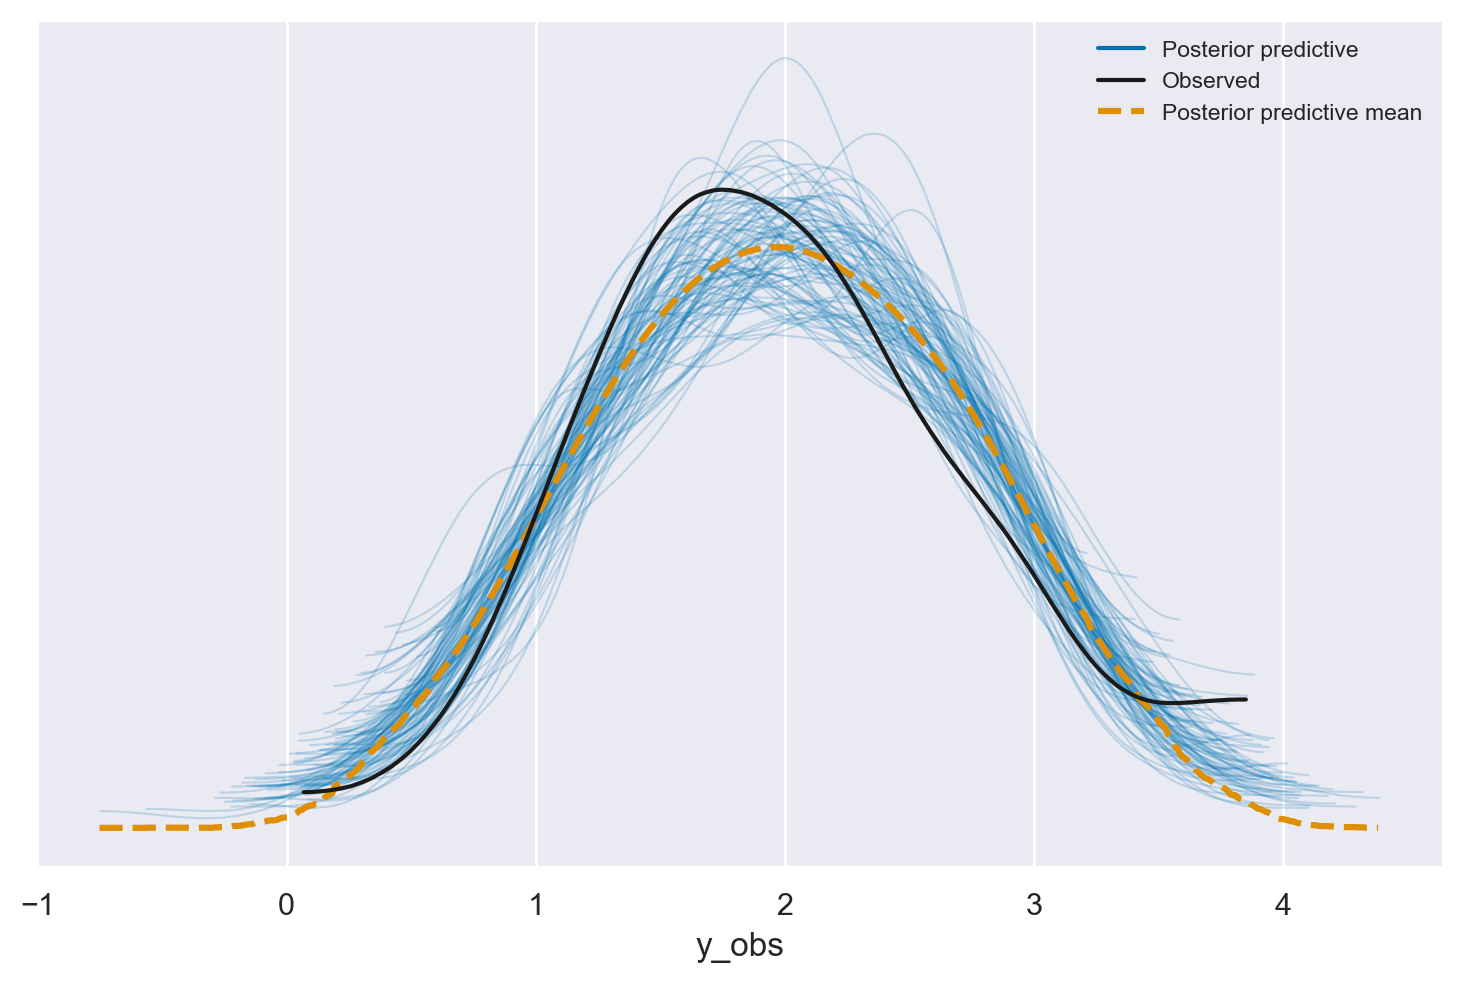

In [41]:
az.plot_ppc(idata, num_pp_samples=100)
plt.show()

In [42]:
%run ../wtrmrk.py

Watermark:
----------
Last updated: 2024-01-26T18:50:26.847773+01:00

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.19.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit


